In [1]:
# autoreload
%reload_ext autoreload
%autoreload 2

## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [1]:
### imports
# general
import pandas as pd
import re
import googlemaps

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# custom
from calcification import utils

In [3]:
### load data
fp = "data/Orlando_data.xlsx"
df = pd.read_excel(fp, sheet_name="all_data")
df = utils.process_df(df)

# create column and fill with cleaned coordinates, where 
df['loc'] = df['cleaned_coords'].fillna(df['location'])
df['loc'].value_counts()

loc
Key West, Florida Keys                                         605
21°26′6″ N, 157°47′12″ W                                       428
Key Biscayne, Florida Keys                                     317
Florida Bay, Florida Keys                                      241
24.56257° N, 81.40009° W                                       236
Mo'orea, French Polynesia                                      205
Hawaii, various                                                201
Almirante Bay, Panama                                          143
Indo-Pacific                                                   106
Gulf of Aqaba-Eilat, Israel                                     96
20°54′19.80″N, 86°50′6.20″W                                     64
Island Point, Panama                                            36
Oku Reef, Okinawa, Japan                                        30
Biscayne National Park, Florida Keys                            20
Spermonde Archipelago, Sulawesi, Indonesia                

In [ ]:
### get locations for which there are no coordinates (from location, where cleaned_coords is NaN)
locs = df.loc[df['cleaned_coords'].isna(), 'location'].unique()
# get coordinates for these locations using Google Maps API
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml("api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

for loc in locs:
    gmaps_coords[loc] = tuple(utils.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column
gmaps_coords

{'Palmyra Atoll': (5.8885026, -162.0786656),
 'Fiji, UK aquarium': (55.378051, -3.435973),
 'M': (None, None),
 'Fiji': (-17.713371, 178.065032),
 'Island Point, Panama': (8.537981, -80.782127),
 "Mo'orea, French Polynesia": (-17.5388435, -149.8295234),
 'Almirante Bay, Panama': (9.2993407, -82.2311642),
 'Hawaii, various': (19.8986819, -155.6658568),
 'Oku Reef, Okinawa, Japan': (26.8271449, 128.2796738),
 'Spermonde Archipelago, Sulawesi, Indonesia': (-4.8755556, 119.1144444),
 'Indo-Pacific': (None, None),
 'Biscayne National Park, Florida Keys': (25.5722, -80.2321),
 'Key West, Florida Keys': (24.5550593, -81.7799871),
 'Key Biscayne, Florida Keys': (25.693713, -80.1628248),
 'Florida Bay, Florida Keys': (24.9586323, -80.67985209999999),
 'Florida Keys National Marine Sanctuary': (24.4269857, -83.11127979999999),
 'Gulf of Aqaba-Eilat, Israel': (29.557669, 34.951925)}

In [ ]:
# fill loc with standardised cleaned_coords if not NaN, otherwise fill with coordinates extracted from location
df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None).fillna(df['location'].map(gmaps_coords))
print(df['loc'].value_counts())
df['latitude'] = df['loc'].apply(lambda x: x[0] if x else None)
df['longitude'] = df['loc'].apply(lambda x: x[1] if x else None)

loc
(24.5550593, -81.7799871)                     605
(21.435, -157.78666666666666)                 428
(25.693713, -80.1628248)                      317
(24.9586323, -80.67985209999999)              241
(24.56257, -81.40009)                         236
(-17.5388435, -149.8295234)                   205
(19.8986819, -155.6658568)                    201
(9.2993407, -82.2311642)                      143
(None, None)                                  118
(29.557669, 34.951925)                         96
(20.9055, -86.83505555555556)                  64
(8.537981, -80.782127)                         36
(26.8271449, 128.2796738)                      30
(25.5722, -80.2321)                            20
(-4.8755556, 119.1144444)                      18
(-17.713371, 178.065032)                       17
(-14.692277777777779, 145.45923611111112)      16
(21.942999999999998, 120.75550000000001)       12
(25.02, -80.49)                                11
(55.378051, -3.435973)                        

In [ ]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values

locs_df = df.set_index('doi').drop_duplicates(['location', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# save dictionary to yaml
utils.write_yaml(locs_dict, "data/locations.yaml")
print('Saved locations to "data/locations.yaml"')
locs_df.to_csv("data/locations.csv", index=True, index_label='doi')
print('Saved locations to "data/locations.csv"')
locs_df

Saved locations to "data/locations.yaml"
Saved locations to "data/locations.csv"


,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8,"Mo'orea, French Polynesia",-17.477919,-149.839667
10.3354/meps10981,"Key Largo, Florida, US",25.020000,-80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,-80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
10.1007/s13131-022-2037-x,South China Sea,17.050000,111.300000
10.1016/j.chemgeo.2018.09.004,"Fiji, UK aquarium",55.378051,-3.435973
10.1007/s00338-019-01775-y,"Heron Island, GBR, Australia",-23.433333,151.866667
10.3390/jmse10081106,Fiji,-17.713371,178.065032
10.1098/rsos.220760,"Island Point, Panama",8.537981,-80.782127


## Visualising

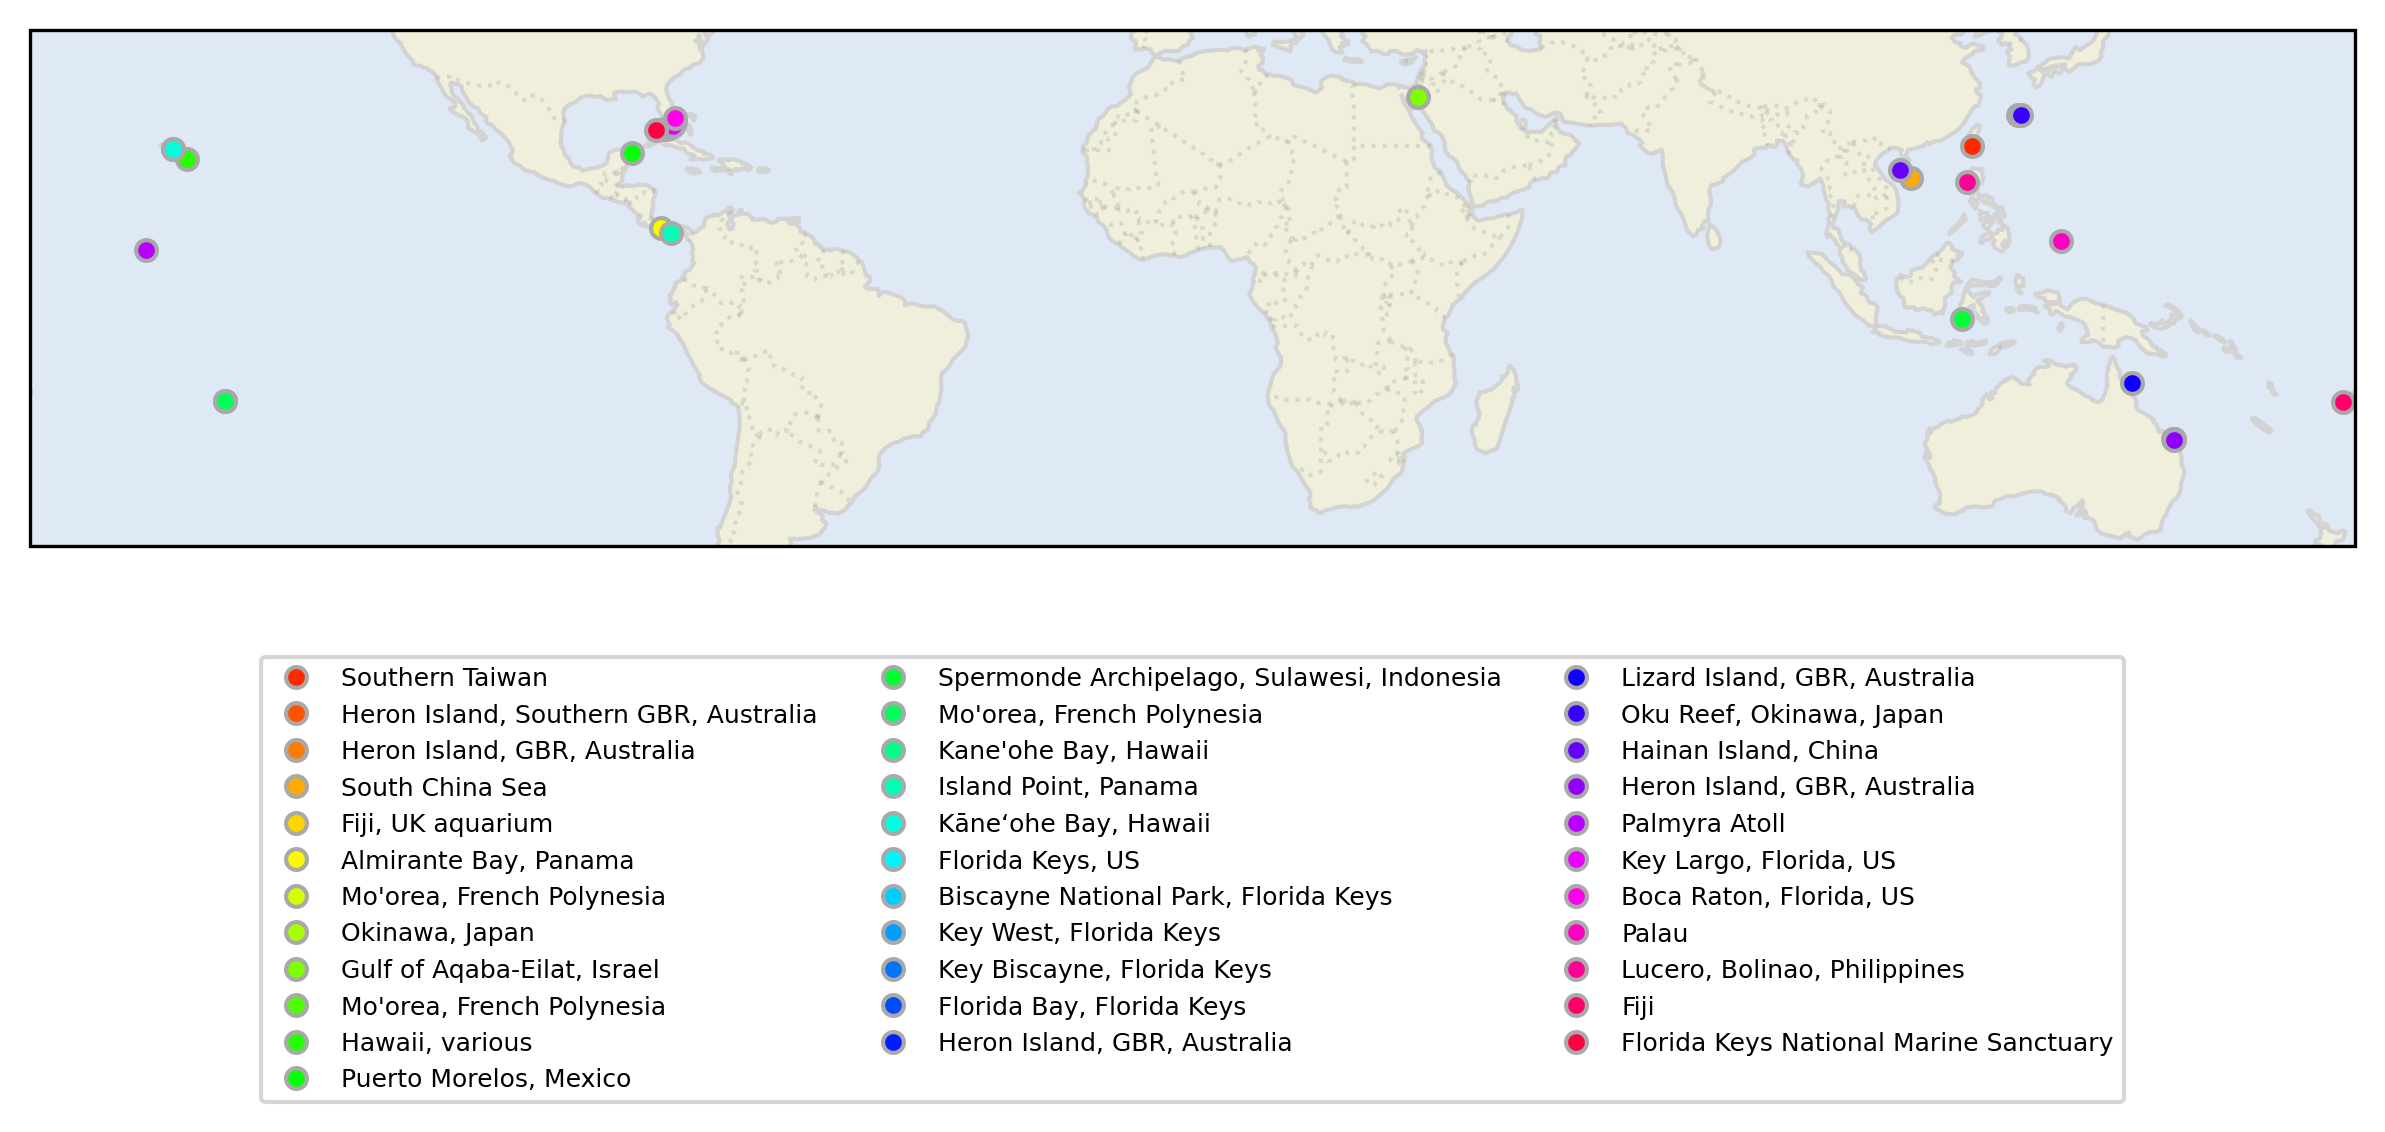

In [ ]:
### plot spatial disribution of studies

locs = utils.read_yaml("data/locations.yaml")   # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()  # drop nans

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
for i, (doi, row) in enumerate(locs_df.iterrows()):
    data = locs[doi]
    ax.plot(data["longitude"], data["latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1), ncol=len(locs_df)//10, fontsize=6);   # add legend